**Problem Statement:**
Your Marketing department would like to contextualize companies website to show viable products your customers might purchase based on past orders/transactions. To help with this effort, the Marketing department contacted you to build an ML model. Analyze the provided dataset and build a predictive model to predict the probability that a given customer will buy a "printer-related product."

In [1]:
# Importing the json module for reading input json files
import json

# Importing pandas library for data processing
import pandas as pd

# Importing numpy library for numerical operations
import numpy as np

# Importing matplotlib.pyplot module for creating visualizations
import matplotlib.pyplot as plt

# Importing OneHotEncoder and LabelEncoder from sklearn.preprocessing module
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Importing train_test_split function from sklearn.model_selection module
from sklearn.model_selection import train_test_split

# Importing LogisticRegression, RandomForestClassifier from sklearn.linear_model and sklearn.ensemble modules
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Importing resample function from sklearn.utils module
from sklearn.utils import resample

# Importing accuracy_score, precision_score, recall_score from sklearn.metrics module
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Importing pickle module for model serialization
import pickle


In [2]:
# Function to read a JSON file
def read_json_file(file_path):
    with open(file_path) as file:
        data = json.load(file)
    return data

In [3]:
# Read the JSON files
data_folder = ""  #Relative path

customer_info = read_json_file(data_folder + "customers_info.json")
product_info = read_json_file(data_folder + "product_info.json")
customer_transaction_info = read_json_file(data_folder + "customer_transaction_info.json")
orders_returned_info = read_json_file(data_folder + "orders_returned_info.json")
region_seller_info = read_json_file(data_folder + "region_seller_info.json")


 # Convert JSON data to DataFrame
customer_info_df = pd.DataFrame(customer_info)  # Convert customer_info JSON to DataFrame
product_info_df = pd.DataFrame(product_info["data"])  # Convert product_info JSON data to DataFrame
customer_transaction_info_df = pd.DataFrame(customer_transaction_info['data'], columns=customer_transaction_info['columns'])  # Convert customer_transaction_info JSON data to DataFrame, specifying column names
orders_returned_info_df = pd.DataFrame(orders_returned_info).transpose()  # Convert orders_returned_info JSON data to DataFrame and transpose the resulting DataFrame
region_seller_info_df = pd.DataFrame(region_seller_info)  # Convert region_seller_info JSON to DataFrame

In [4]:
customer_info_df.head()

,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region
0,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South
1,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West
2,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South
3,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West
4,AA-10480,Andrew Allen,Consumer,United States,Concord,North Carolina,28027,South


In [5]:
product_info_df.head()

,index,Product ID,Category,Sub-Category,Product Name
0,0,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase
1,1,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,..."
2,2,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...
3,3,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table
4,4,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System


In [6]:
customer_transaction_info_df.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Product ID,Sales,Quantity,Discount,Profit
0,CA-2016-152156,1478563200000,1478822400000,Second Class,CG-12520,FUR-BO-10001798,261.9600,2,0.00,41.9136
1,CA-2016-152156,1478563200000,1478822400000,Second Class,CG-12520,FUR-CH-10000454,731.9400,3,0.00,219.5820
2,CA-2016-138688,1465689600000,1466035200000,Second Class,DV-13045,OFF-LA-10000240,14.6200,2,0.00,6.8714
3,US-2015-108966,1444521600000,1445126400000,Standard Class,SO-20335,FUR-TA-10000577,957.5775,5,0.45,-383.0310
4,US-2015-108966,1444521600000,1445126400000,Standard Class,SO-20335,OFF-ST-10000760,22.3680,2,0.20,2.5164


In [7]:
orders_returned_info_df.head()

,Returned,Order ID
0,Yes,CA-2017-153822
1,Yes,CA-2017-129707
2,Yes,CA-2014-152345
3,Yes,CA-2015-156440
4,Yes,US-2017-155999


In [8]:
region_seller_info_df.head()

,0,1,2,3
0,Anna Andreadi,West,Femail,45
1,Chuck Magee,East,G,43
2,Kelly Williams,Central,None,35
3,Cassandra Brandow,South,F,9849


# **Data cleaning and preprocessing techniques**

In [9]:
# Ensured the column names are consistent and adjusted where necessary
region_seller_info_df.rename(columns={1: "Region"}, inplace=True)
region_seller_info_df.rename(columns={0: "Seller"}, inplace=True)

In [10]:
'''Based on the sample data you provided, it appears that the 'Order Date' and 'Ship Date' columns are represented as Unix timestamps.
To convert these timestamps to the correct date format, you can use the pd.to_datetime() function from the pandas library. '''
# Convert 'Order Date' and 'Ship Date' columns to datetime format

customer_transaction_info_df['Order Date'] = pd.to_datetime(customer_transaction_info_df['Order Date'], unit='ms')
customer_transaction_info_df['Ship Date'] = pd.to_datetime(customer_transaction_info_df['Ship Date'], unit='ms')

In [11]:
# Merge the data frames
merged_df = customer_info_df.merge(customer_transaction_info_df, on="Customer ID", how="left")
merged_df = merged_df.merge(product_info_df, on="Product ID", how="left")
merged_df = merged_df.merge(orders_returned_info_df, on="Order ID", how="left")
merged_df = merged_df.merge(region_seller_info_df, on="Region", how="left")


In [12]:
merged_df.columns

Index([  'Customer ID', 'Customer Name',       'Segment',       'Country',
                'City',         'State',   'Postal Code',        'Region',
            'Order ID',    'Order Date',     'Ship Date',     'Ship Mode',
          'Product ID',         'Sales',      'Quantity',      'Discount',
              'Profit',         'index',      'Category',  'Sub-Category',
        'Product Name',      'Returned',        'Seller',               2,
                     3],
      dtype='object')

Check for null / Missing values

In [13]:
merged_df.isnull().sum()

Customer ID          0
Customer Name        0
Segment              0
Country              0
City                 0
State                0
Postal Code          0
Region               0
Order ID             0
Order Date           0
Ship Date            0
Ship Mode            0
Product ID           0
Sales                0
Quantity             0
Discount             0
Profit               0
index                0
Category             0
Sub-Category         0
Product Name         0
Returned         68360
Seller               0
2                17628
3                    0
dtype: int64

In [14]:
# Replace null values in the "products returned" column with "No"
column_name = "Returned"
specific_value = "No"

merged_df[column_name] = merged_df[column_name].fillna(specific_value)

**EDA**

In [15]:
# Count the number of unique values in each categorical column
categorical_cols = ['Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
                    'Region', 'Order ID', 'Ship Mode', 'Product ID', 'Category', 'Sub-Category',
                    'Product Name', 'Returned', 'Seller',"Order Date","Ship Date"]
for col in categorical_cols:
    unique_count = merged_df[col].nunique()
    print(f"Number of unique values in '{col}': {unique_count}")


Number of unique values in 'Customer ID': 793
Number of unique values in 'Customer Name': 793
Number of unique values in 'Segment': 3
Number of unique values in 'Country': 1
Number of unique values in 'City': 531
Number of unique values in 'State': 49
Number of unique values in 'Region': 4
Number of unique values in 'Order ID': 5009
Number of unique values in 'Ship Mode': 4
Number of unique values in 'Product ID': 1862
Number of unique values in 'Category': 3
Number of unique values in 'Sub-Category': 17
Number of unique values in 'Product Name': 1850
Number of unique values in 'Returned': 2
Number of unique values in 'Seller': 4
Number of unique values in 'Order Date': 1237
Number of unique values in 'Ship Date': 1334


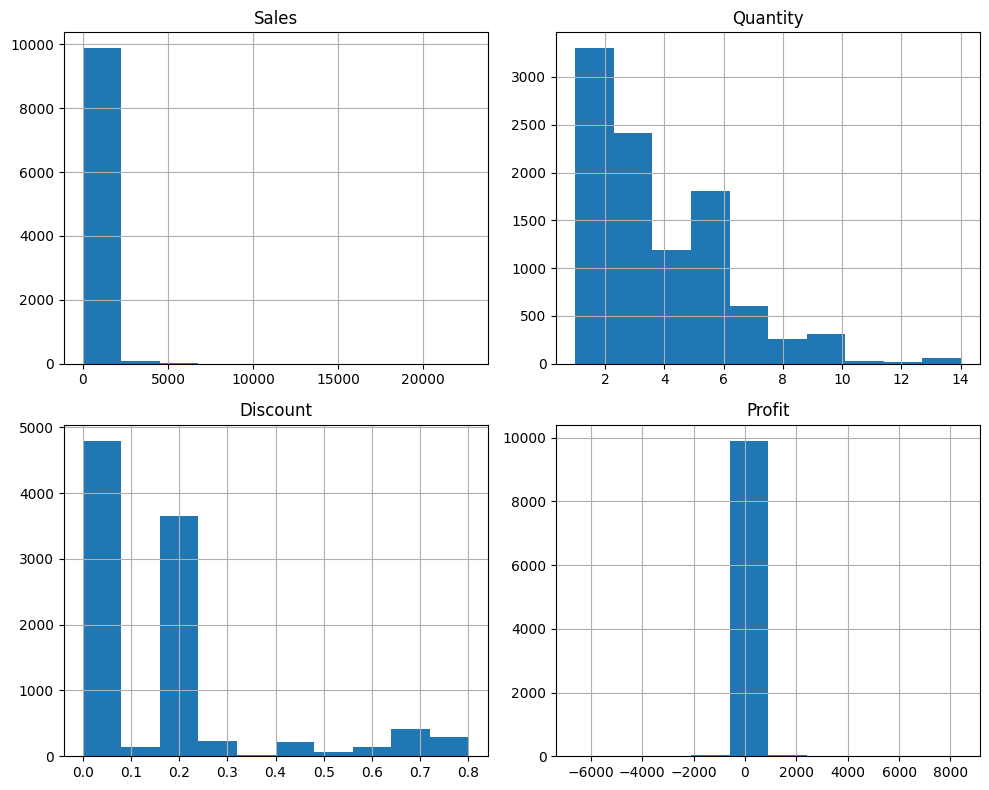

In [16]:
# Explore the distribution of numerical variables
numeric_cols = ['Sales', 'Quantity', 'Discount', 'Profit']
customer_transaction_info_df[numeric_cols].hist(bins=10, figsize=(10, 8))
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

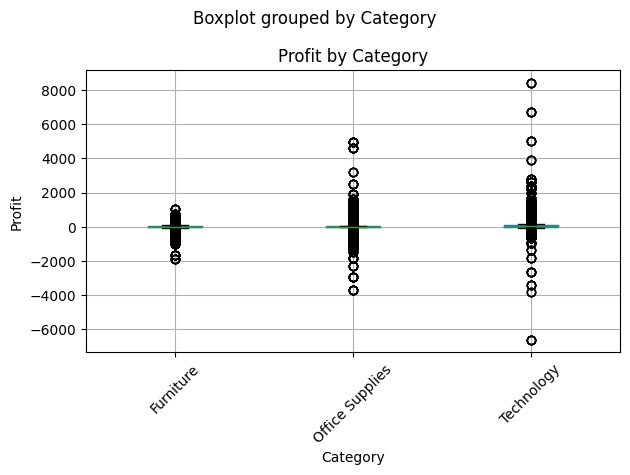

In [17]:
# Box plot of Profit by Category
plt.figure(figsize=(10, 6))
merged_df.boxplot(column='Profit', by='Category')
plt.title('Profit by Category')
plt.xlabel('Category')
plt.ylabel('Profit')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

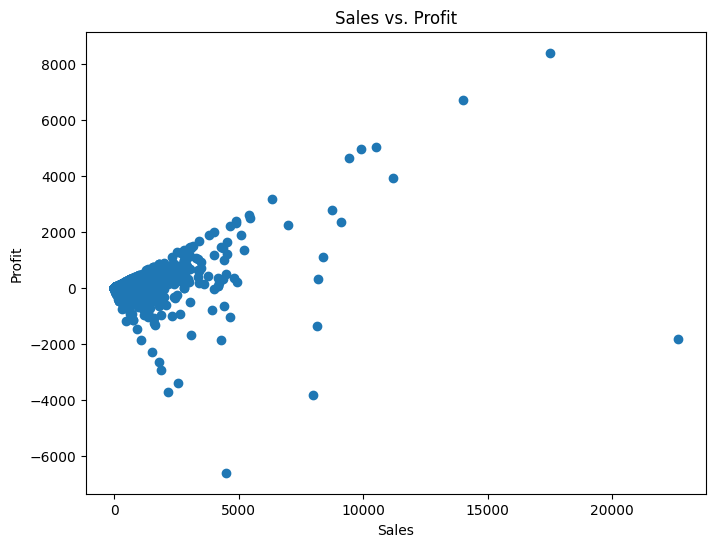

In [18]:
# Explore the relationship between variables
# Scatter plot of Sales vs. Profit
plt.figure(figsize=(8, 6))
plt.scatter(customer_transaction_info_df['Sales'], customer_transaction_info_df['Profit'])
plt.title('Sales vs. Profit')
plt.xlabel('Sales')
plt.ylabel('Profit')
plt.show()


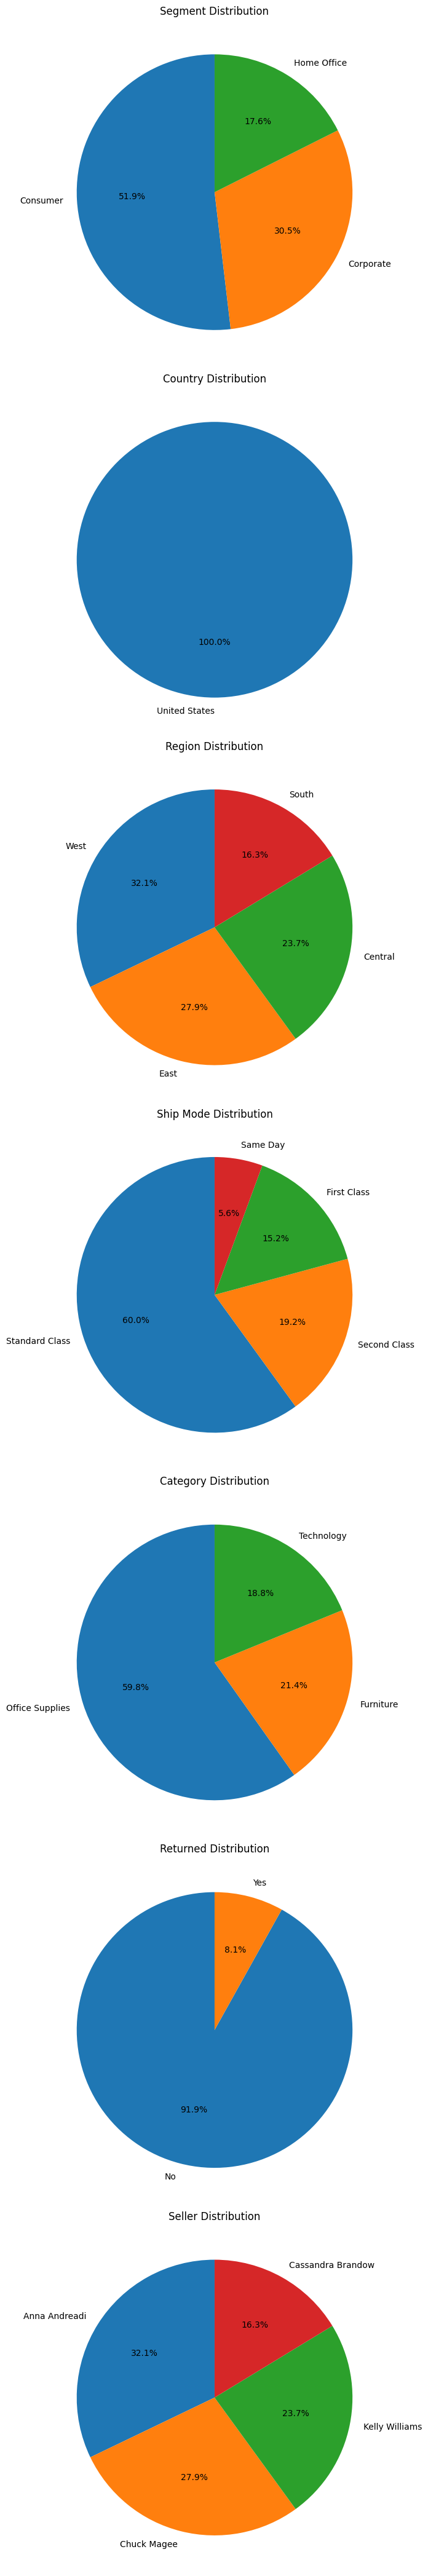

In [19]:

# Categorical variables for pie chart
categorical_vars = ['Segment', 'Country', 'Region', 'Ship Mode', 'Category', 'Returned', 'Seller']

# Set up the figure and axes
fig, axes = plt.subplots(len(categorical_vars), 1, figsize=(8, 6*len(categorical_vars)))

# Iterate over categorical variables
for i, var in enumerate(categorical_vars):
    # Count the occurrences of each category
    counts = merged_df[var].value_counts()

    # Plot the pie chart
    axes[i].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'{var} Distribution')
    axes[i].set_aspect('equal')  # Ensure circular pie chart

# Adjust the spacing between subplots
plt.tight_layout()

# Display the pie chart
plt.show()


# **Analysis of Printer Related Products**

In [20]:
# Apply filters or conditions to retrieve specific rows
printer_related_products = merged_df[
    merged_df["Product Name"].str.contains("printer", case=False) &
    (merged_df["Sub-Category"] == "Machines")
]

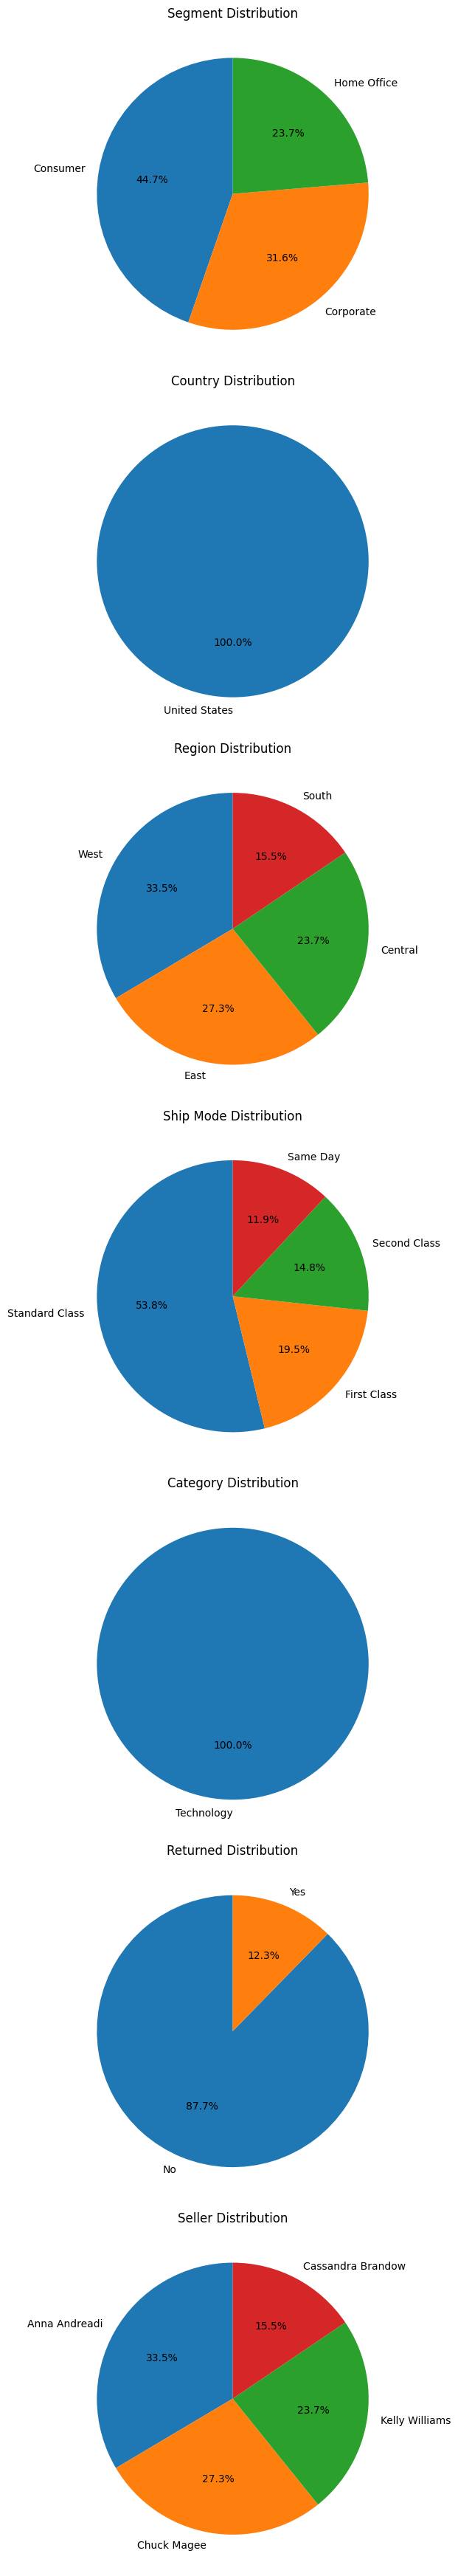

In [21]:

# Categorical variables for pie chart
categorical_vars = ['Segment', 'Country', 'Region', 'Ship Mode', 'Category', 'Returned', 'Seller']

# Set up the figure and axes
fig, axes = plt.subplots(len(categorical_vars), 1, figsize=(7, 5*len(categorical_vars)))

# Iterate over categorical variables
for i, var in enumerate(categorical_vars):
    # Count the occurrences of each category
    counts = printer_related_products[var].value_counts()

    # Plot the pie chart
    axes[i].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'{var} Distribution')
    axes[i].set_aspect('equal')  # Ensure circular pie chart

# Adjust the spacing between subplots
plt.tight_layout()

# Display the pie chart
plt.show()


In [22]:
# Assuming 'df' is your DataFrame and 'Order Date' and 'Ship Date' are in a suitable format
order_dates = printer_related_products['Order Date']
ship_dates = printer_related_products['Ship Date']

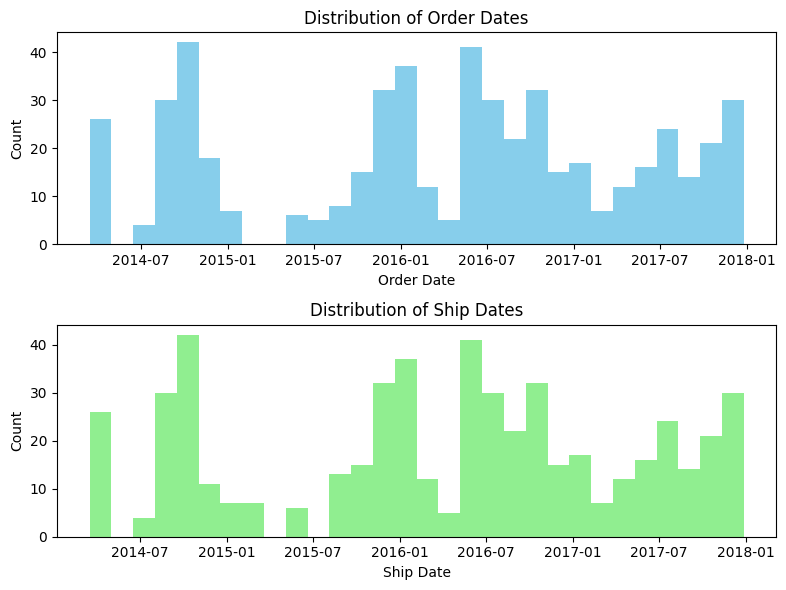

In [23]:
# Set up the figure and axes
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

# Plot the histogram for 'Order Date'
axes[0].hist(order_dates, bins=30, color='skyblue')
axes[0].set_title('Distribution of Order Dates')
axes[0].set_xlabel('Order Date')
axes[0].set_ylabel('Count')

# Plot the histogram for 'Ship Date'
axes[1].hist(ship_dates, bins=30, color='lightgreen')
axes[1].set_title('Distribution of Ship Dates')
axes[1].set_xlabel('Ship Date')
axes[1].set_ylabel('Count')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the histograms
plt.show()


In [24]:
print(printer_related_products.shape)
print(merged_df.shape) #Out of 74378 orders only 528  orders for printer related products

(528, 25)
(74378, 25)


In [25]:
printer_related_products.groupby('Ship Mode')['Ship Mode'].agg('count')

Ship Mode
First Class       103
Same Day           63
Second Class       78
Standard Class    284
Name: Ship Mode, dtype: int64

In [26]:
printer_related_products.groupby('Region')['Region'].agg('count')

Region
Central    125
East       144
South       82
West       177
Name: Region, dtype: int64

In [27]:
printer_related_products.groupby('Segment')['Segment'].agg('count')

Segment
Consumer       236
Corporate      167
Home Office    125
Name: Segment, dtype: int64

<ipython-input-28-c351ff985c30>:8: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modified_state_counts = top_states.append(pd.Series(other_states_count, index=['Others']))


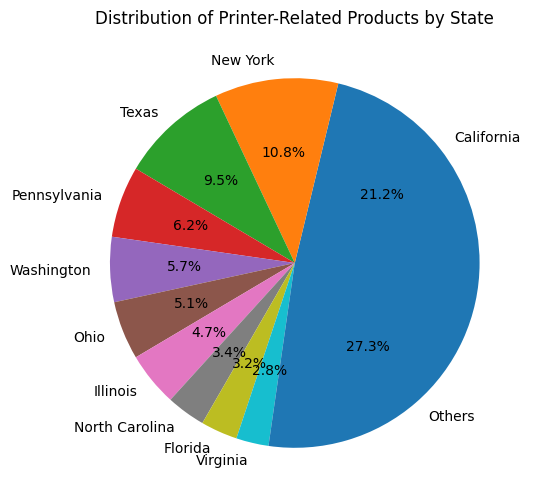

In [28]:
#'state_counts' contains the counts of all states
state_counts = printer_related_products['State'].value_counts()

top_states = state_counts.head(10)
other_states_count = state_counts.iloc[10:].sum()

# Creating a new DataFrame for the modified data
modified_state_counts = top_states.append(pd.Series(other_states_count, index=['Others']))

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(modified_state_counts, labels=modified_state_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Printer-Related Products by State')

# Display the pie chart
plt.show()

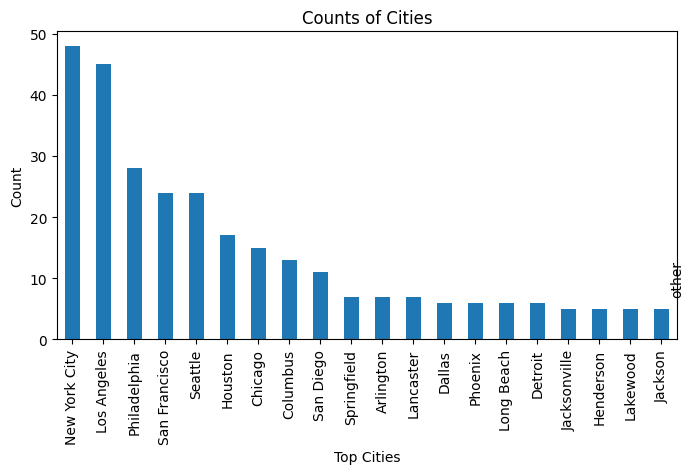

In [29]:
#'state_counts' contains the counts of all states
city_counts = printer_related_products['City'].value_counts()
top_cities = city_counts.head(20)
# Plotting the vertical bar plot
plt.figure(figsize=(8, 4))
top_cities.plot(kind='bar')
plt.xlabel('Top Cities')
plt.ylabel('Count')
plt.title('Counts of Cities')

# Adding a custom label for the "other" category
plt.text(len(top_cities)-0.5, 10, 'other', fontsize=10, ha='center', va='center', rotation=90)

# Display the plot
plt.show()

In [30]:
# Create a new column 'printer_related_product' with default value 'no'
merged_df['printer_related_product'] = 'no'

In [31]:
merged_df.loc[(merged_df['Product Name'].str.contains('printer', case=False)) & (merged_df['Sub-Category'] == 'Machines'), 'printer_related_product'] = 'yes'

In [32]:
merged_df.head()

,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Order ID,Order Date,...,Profit,index,Category,Sub-Category,Product Name,Returned,Seller,2,3,printer_related_product
0,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,CA-2016-152156,2016-11-08,...,41.9136,0,Furniture,Bookcases,Bush Somerset Collection Bookcase,No,Cassandra Brandow,F,9849,no
1,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,CA-2016-152156,2016-11-08,...,219.5820,1,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",No,Cassandra Brandow,F,9849,no
2,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,CA-2017-164098,2017-01-26,...,1.8160,77,Office Supplies,Storage,"SimpliFile Personal File, Black Granite, 15w x...",No,Cassandra Brandow,F,9849,no
3,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,US-2015-123918,2015-10-15,...,-95.2476,1167,Furniture,Furnishings,C-Line Cubicle Keepers Polyproplyene Holder w/...,No,Cassandra Brandow,F,9849,no
4,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,US-2015-123918,2015-10-15,...,1.8704,1651,Office Supplies,Paper,Xerox 1986,No,Cassandra Brandow,F,9849,no


In [33]:
# Drop irrelevant columns
merged_df = merged_df.drop([2,3, 'index', 'Category', 'Sub-Category','Country','Customer ID', 'Customer Name',  'Postal Code', 'Order ID', 'Order Date', 'Ship Date',
       'Ship Mode', 'Product ID', 'Sales', 'Quantity', 'Discount', 'Profit',
       'Product Name', 'Returned', 'Seller'], axis=1)


In [34]:
merged_df.columns

Index(['Segment', 'City', 'State', 'Region', 'printer_related_product'], dtype='object')

In [35]:
merged_df.head()

,Segment,City,State,Region,printer_related_product
0,Consumer,Henderson,Kentucky,South,no
1,Consumer,Henderson,Kentucky,South,no
2,Consumer,Henderson,Kentucky,South,no
3,Consumer,Henderson,Kentucky,South,no
4,Consumer,Henderson,Kentucky,South,no


In [36]:
# Perform label encoding
label_encoder = LabelEncoder()
merged_df["printer_related_product"] = label_encoder.fit_transform(merged_df["printer_related_product"])

In [37]:

# Select the categorical feature(s) to encode
categorical_features = ['Segment']

# One-Hot Encoding
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = one_hot_encoder.fit_transform(merged_df[categorical_features])

# Create a new DataFrame with the one-hot encoded features
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_features))

# Concatenate the one-hot encoded features with the original dataset
data_encoded_one_hot = pd.concat([merged_df.drop(categorical_features, axis=1), one_hot_encoded_df], axis=1)
# Remove one column from the one-hot encoding output - To avoid multicolinearity
data_encoded_one_hot = data_encoded_one_hot.drop('Segment_Home Office', axis=1)


#encode the data
data_encoded_dummies=pd.get_dummies(data=merged_df[["Region"]],drop_first=True)
# Concatenate the one-hot encoded features with the original dataset
data_encoded = pd.concat([data_encoded_one_hot.drop("Region", axis=1), data_encoded_dummies], axis=1)


In [38]:
def one_hot_top_x(df,variable,top_x_labels):
  for label in top_x_labels:
    df[variable+'_'+label]=np.where(df[variable]==label,1,0)
  df.drop([variable], axis=1, inplace=True)


In [39]:
top_cities_list=top_cities.index.tolist()


In [40]:
top_states_list=top_states.index.tolist()

In [41]:
one_hot_top_x(data_encoded,'City',top_cities_list)


In [42]:
one_hot_top_x(data_encoded,'State',top_states_list)

In [43]:
data_encoded.head()

,printer_related_product,Segment_Consumer,Segment_Corporate,Region_East,Region_South,Region_West,City_New York City,City_Los Angeles,City_Philadelphia,City_San Francisco,...,State_California,State_New York,State_Texas,State_Pennsylvania,State_Washington,State_Ohio,State_Illinois,State_North Carolina,State_Florida,State_Virginia
0,0,1.0,0.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1.0,0.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1.0,0.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1.0,0.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1.0,0.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **We can see data is imbalanced**

In [44]:
data_encoded.groupby('printer_related_product')['printer_related_product'].agg('count')

printer_related_product
0    73850
1      528
Name: printer_related_product, dtype: int64

To address the issue of an imbalanced dataset where the majority class dominates the minority class, one common approach is to use stratified sampling or stratified splitting techniques. **Stratification ensures that the class distribution is preserved in the training and testing datasets**, allowing the model to learn from and make accurate predictions for both classes.

In [45]:
X=data_encoded.drop("printer_related_product",axis=1)
y=data_encoded["printer_related_product"]

In [46]:

# Concatenate X and y into a single DataFrame
df = pd.concat([X, y], axis=1)
# Separate majority and minority class
df_majority = df[df['printer_related_product'] == 0]

df_minority = df[df['printer_related_product'] == 1]

# Undersample the majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,  # Set to False for undersampling
                                   n_samples=len(df_minority),  # Match the number of minority class samples
                                   random_state=42)

# Combine the downsampled majority class with the minority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Separate features (X) and target variable (y) from the downsampled dataset
X_downsampled = df_downsampled.drop('printer_related_product', axis=1)
y_downsampled = df_downsampled['printer_related_product']

print("Class Distribution after Undersampling:")
print(y_downsampled.value_counts())

Class Distribution after Undersampling:
0    528
1    528
Name: printer_related_product, dtype: int64


Limited Information: **Undersampling reduces the majority class instances, potentially resulting in a loss of valuable information and reducing the model's ability to learn patterns from the majority class. With a smaller training set, the model may struggle to capture the complexities of the data**.

In [52]:

# Split the downsampled data into features (X_downsampled) and target variable (y_downsampled)
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_downsampled,stratify=y_downsampled, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg.predict(X_test)


**Model Evaluation**

In [53]:
# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the evaluation metrics
print("Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Model Performance:
Accuracy: 0.5094
Precision: 0.5114
Recall: 0.4245


In [54]:

# Split the downsampled data into features (X_downsampled) and target variable (y_downsampled)
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_downsampled,stratify=y_downsampled, test_size=0.2)

# Initialize and train the Random Forest classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the evaluation metrics
print("Random Forest Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Random Forest Model Performance:
Accuracy: 0.4764
Precision: 0.4742
Recall: 0.4340


In [55]:
# Make predictions on the test set
y_pred_proba = rf.predict_proba(X_test)

# Extract the probability of the positive class ('yes')
printer_related_probabilities = y_pred_proba[:, 1]

# Print the probabilities for the printer-related product
print("Probabilities for Printer-Related Product:")
print(printer_related_probabilities)


Probabilities for Printer-Related Product:
[0.67080406 0.43360317 0.71070976 0.70553343 0.7079491  0.64522999
 0.67988349 0.36222753 0.3915772  0.22183264 0.67988349 0.76880159
 0.52547212 0.37050295 0.41723927 0.32282998 0.49918579 0.58831798
 0.92083333 0.41723927 0.5241542  0.5930413  0.3915772  0.41723927
 0.54004892 0.46503691 0.5815693  0.42976211 0.22183264 0.68913062
 0.46503691 0.44489139 0.29391921 0.27236558 0.5930413  0.32754895
 0.3915772  0.26091255 0.3915772  0.58831798 0.5241542  0.46503691
 0.37318581 0.32282998 0.32559524 0.54004892 0.37665903 0.29391921
 0.37781941 0.5815693  0.37050295 0.58831798 0.42976211 0.51391375
 0.30509267 0.38317857 0.36222753 0.37781941 0.58831798 0.32282998
 0.70553343 0.65709996 0.70571392 0.46503691 0.49121969 0.30509267
 0.5930413  0.22183264 0.69750244 0.00166667 0.5241542  0.70553343
 0.22183264 0.32754895 0.48621642 0.3503962  0.79466381 0.70553343
 0.36222753 0.41723927 0.52547212 0.32282998 0.32754895 0.62116929
 0.37792862 0.69168

 The trained models, 'rf' (Random Forest) and 'logreg' (Logistic Regression), are saved as pickle files using the pickle.dump() function.

The models are saved with the specified filenames ('RandomForestClassifier.pkl' and 'LogisticRegression.pkl'). The 'wb' mode is used to write the serialized models as binary files.

In [56]:

with open(r'RandomForestClassifier.pkl', 'wb') as model_pkl:
    pickle.dump(rf, model_pkl)

with open(r'LogisticRegression.pkl', 'wb') as model_pkl:
    pickle.dump(logreg, model_pkl)

